In [1]:
#Pierce Zhang, CMOR220, Fall 2023, Bridge Project
#bridge.ipynb
#Script to execute the bridge project
#Last Modified: December 5, 2023

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def build_basic_bridge(nos):
    """
    Inputs:
        - nos, (integer) the number of sections in the bridge
    Outputs:
        - adj, (np.ndarray) the adjacency matrix of the bridge
        - xc, (np.ndarray) the x-coords of the bridge fibers
        - yc, (np.ndarray) the y-coords of the bridge fibers
        - len, (np.ndarray) the lengths of each bridge fiber
    """
    # Helpful quantification variables
    nodes = 2*nos+2
    beams = 5*nos+5
    xc = np.zeros((beams, 2))
    yc = np.zeros((beams, 2))
    length = np.ones(beams)
    s = np.sqrt(2)
    
    #Adjacency generation
    adj = np.zeros((beams,2*nodes))
    # Left end
    adj[0,0]=1
    adj[1,[2,3]]=[1/s,1/s]
    # Middle sections
    for n in range(1,nos+1):
        R=5*n-3
        C=4*n-4
        adj[R+0,[C+0,C+1,C+2,C+3]]=[0,-1,0,1]
        adj[R+1,[C+2,C+3,C+4,C+5]]=[-1/s,1/s,1/s,-1/s]
        adj[R+2,[C+2,C+3,C+6,C+7]]=[-1,0,1,0]
        adj[R+3,[C+0,C+1,C+6,C+7]]=[-1/s,-1/s,1/s,1/s]
        adj[R+4,[C+0,C+1,C+4,C+5]]=[-1,0,1,0]
    # Right end
    adj[-3,-3:]=[-1, 0, 1]
    adj[-1,-4]=-1
    adj[-2,-2:]=[-1/s, 1/s]
    
    # Coordinate generation
    # X-values
    xc[0:2,:] = [0,1]
    for n in range(nos):
        xc[5*n+2]=n+1
        xc[5*n+3:5*n+7]=[n+1,n+2]
    xc[-2:,:] = [nos+1,nos+2]
    xc[-3,:] = [nos+1,nos+1]
    # Y-values
    yc[1:3,:] = [0,1]
    for n in range(nos):
        yc[5*n+3:5*n+8]=np.array(([1,0],[1,1],[0,1],[0,0],[0,1]))
    yc[-2,:] = [1,0]
    
    # Length generation
    length[1] = s
    length[3] = s
    for n in range(nos):
        length[5*n+5] = s
        length[5*n+8] = s
        
    return adj, xc, yc, length

In [4]:
def construct_force_vector(nos, car_weight):
    """
    Inputs:
        - nos, (integer) the number of sections in the bridge
        - car_weight, (float) the car weight
    Outputs:
        - force, (np.ndarray) the force vector
    """
    # Force vector of right length
    force = np.zeros(4*nos+4)
    # Skip nodes so that only the bottomside is pulled down
    for n in range(1,len(force),4):
        force[n] = -car_weight    
    return force

In [5]:
def deform_basic_bridge(nos, adj, xc, yc, length, force):
    """
    Inputs:
        - nos, (integer) the number of sections in the bridge
        - adj, (np.matrix) the adjacency matrix of the bridge
        - xc, (np.ndarray) the x-coords of the bridge fibers
        - yc, (np.ndarray) the y-coords of the bridge fibers
        - len, (np.ndarray) the lengths of each bridge fiber
        - force, (np.ndarray) the weight of the car on the bridge
    Outputs:
        - dx, (np.ndarray) the new x-coords of the bridge fibers
        - dy, (np.ndarray) the new y-coords of the bridge fibers
        - work, (integer) measures how the bridge has deformed
        - X, (np.ndarray) the horizontal displacement of each node
        - Y, (np.ndarray) the vertical displacement of each node
    """
    # Prepare system of equations and solve for displacement
    stiffness=np.transpose(adj)@np.diag(np.divide(1,length))@adj
    displacements = np.linalg.solve(stiffness,force)
    work = np.transpose(displacements)@force
    # Displacement carrier
    X = displacements[::2]
    Y = displacements[1::2]
    
    # Apply carrier values
    dx = np.zeros((xc.shape))
    dy = np.zeros((yc.shape))
    # Deform left
    dx[0] = xc[0] + [0, X[0]]
    dy[0] = yc[0] + [0, Y[0]]
    dx[1] = xc[1] + [0, X[1]]
    dy[1] = yc[1] + [0, Y[1]]
    # Deform middle
    for n in range(1,nos+1):
        R = 5*n-3
        dx[R+0,:] = xc[R+0,:]+[X[2*n-2],X[2*n-1]]
        dy[R+0,:] = yc[R+0,:]+[Y[2*n-2],Y[2*n-1]]
        # Second group of nodes
        dx[R+1,:] = xc[R+1,:]+[X[2*n-1],X[2*n]]
        dy[R+1,:] = yc[R+1,:]+[Y[2*n-1],Y[2*n]]
        # Third group of nodes
        dx[R+2,:] = xc[R+2,:]+[X[2*n-1],X[2*n+1]]
        dy[R+2,:] = yc[R+2,:]+[Y[2*n-1],Y[2*n+1]]
        # Fourth group of nodes
        dx[R+3,:] = xc[R+3,:]+[X[2*n-2],X[2*n+1]]
        dy[R+3,:] = yc[R+3,:]+[Y[2*n-2],Y[2*n+1]]
        # Last group of nodes
        dx[R+4,:] = xc[R+4,:]+[X[2*n-2],X[2*n]]
        dy[R+4,:] = yc[R+4,:]+[Y[2*n-2],Y[2*n]]
    # Deform right
    dx[-3,:] = xc[-3,:] + [X[-2],X[-1]]
    dy[-3,:] = yc[-3,:] + [Y[-2],Y[-1]]
    dx[-2,:] = xc[-2,:] + [X[-1],0]
    dy[-2,:] = yc[-2,:] + [Y[-1],0]
    dx[-1,:] = xc[-1,:] + [X[-2],0]
    dy[-1,:] = yc[-1,:] + [Y[-2],0]
    return dx, dy, work, X, Y

In [6]:
def plot_spy(nos, adj):
    """
    Plots the sparsity pattern of the adjacency matrix.
    Input:
        - nos, (integer) the number of sections in the bridge
        - adj, (np.ndarray) adjacency matrix of the bridge
    Output: None
    """
    # Initialize figure, plot, and title
    plt.figure()
    plt.spy(adj)
    plt.title(f"Spy plot for {nos} section bridge")
    plt.xlabel("Nonzero columns")
    plt.ylabel("Nonzero rows")

def plot_bridge(nos, xc, yc, car_weight=0, work=0):
    """
    Plots a bridge.
    Input:
        - nos, (integer) the number of sections in the bridge
        - xc, (np.ndarray) the x-coords of the bridge fibers
        - yc, (np.ndarray) the y-coords of the bridge fibers
        - car_weight, (integer) weight of car on bridge
        - work, (integer) work done on the bridge
    Output: None
    """
    plt.figure()
    plt.plot(xc.T,yc.T,"blue")
    right_edge = np.amax(xc)
    plt.fill([0, 0.5, -1, -1], [0, -1, -1, 0], 'k')
    plt.fill([right_edge, right_edge+1, right_edge+1, right_edge-0.5], [0, 0, -1, -1], 'k')
    # Check if it's a basic bridge; if not, plot regularly
    if car_weight==0 and work==0:
        plt.title(f"{nos} Section Basic Bridge")
    else:
        plt.title(f"{nos} Section Deformed Bridge | Car Weight={car_weight} | Work={work}")

In [7]:
def build_load_plot_basic_bridge(nos):
    """
    This function invokes build_basic_bridge, deform_basic_bridge, 
    plot_bridge, and plot_spy to build, deform, and plot the bridge as
    well as its corresponding adjacency matrix.
    Input:
        - nos, (integer) the number of sections in the bridge
    Output: None
    """
    # 0, 0.01, 0.05
    adj,xc_0,yc_0,length = build_basic_bridge(nos)
    plot_spy(nos,adj)
    plot_bridge(nos,xc_0,yc_0)
    
    force = construct_force_vector(nos,0.01)
    dx,dy,work,X,Y = deform_basic_bridge(nos,adj,xc_0,yc_0,length,force)
    plot_bridge(nos,dx,dy,car_weight=0.01,work=work)
    
    force = construct_force_vector(nos,0.05)
    dx,dy,work,X,Y = deform_basic_bridge(nos,adj,xc_0,yc_0,length,force)
    plot_bridge(nos,dx,dy,car_weight=0.05,work=work)

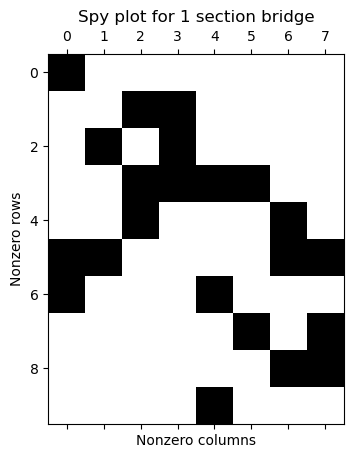

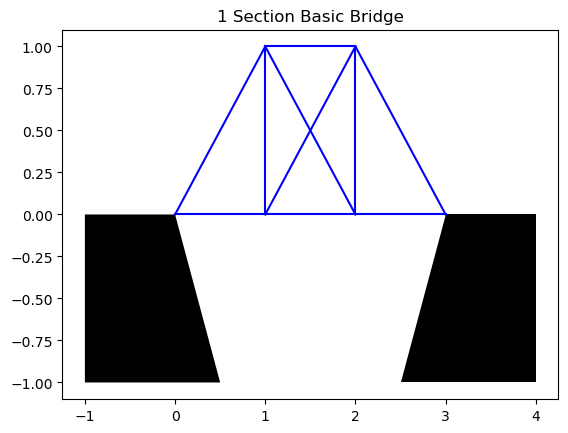

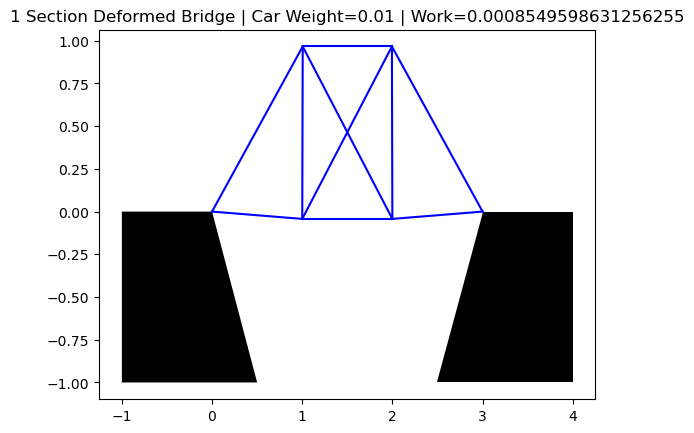

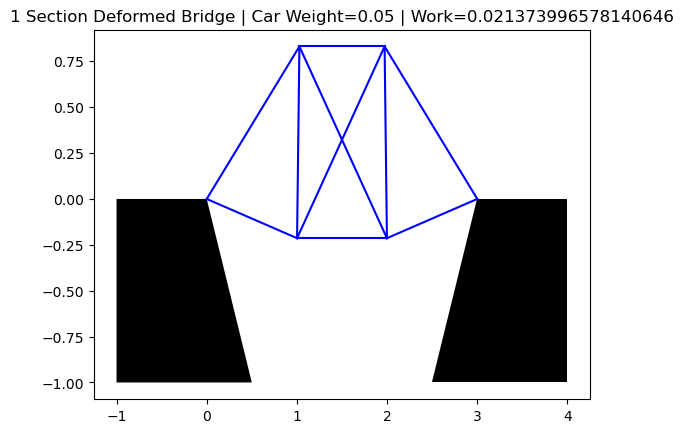

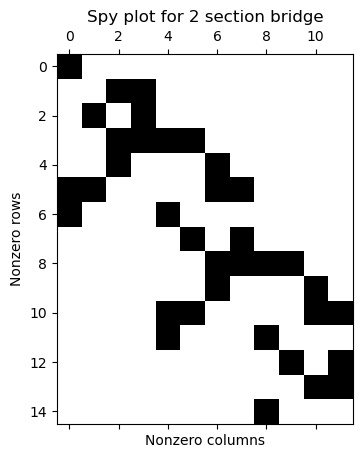

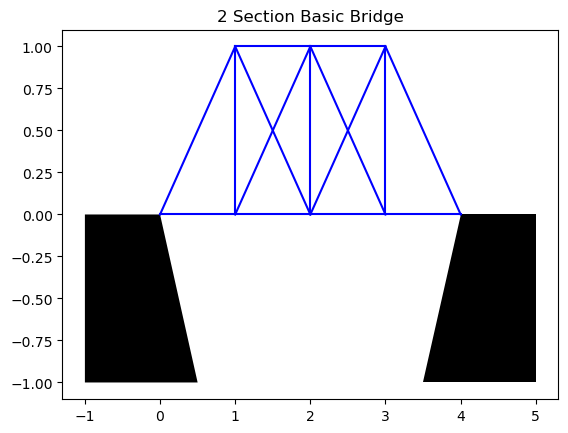

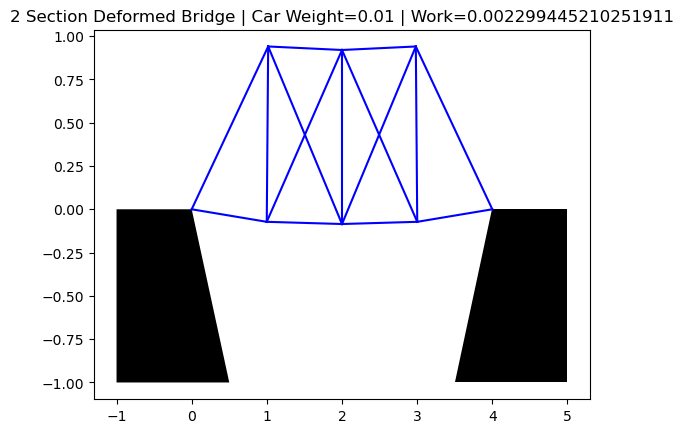

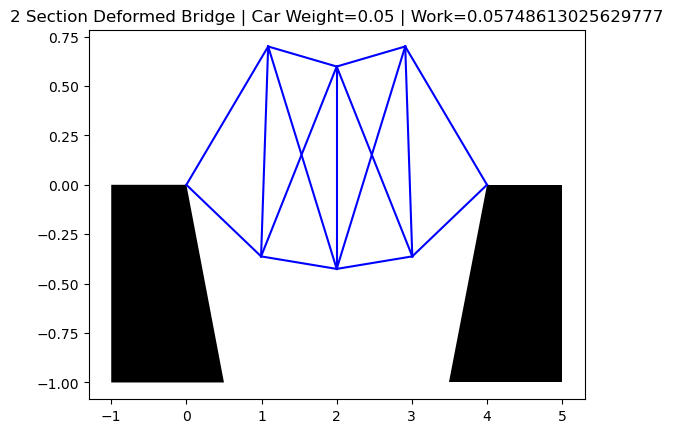

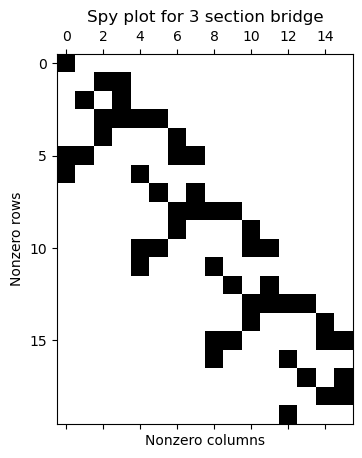

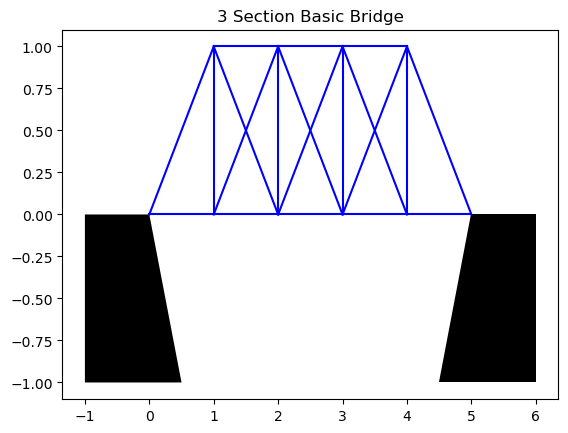

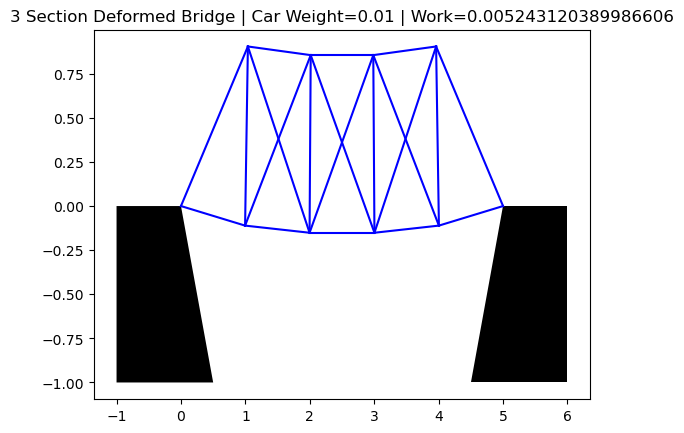

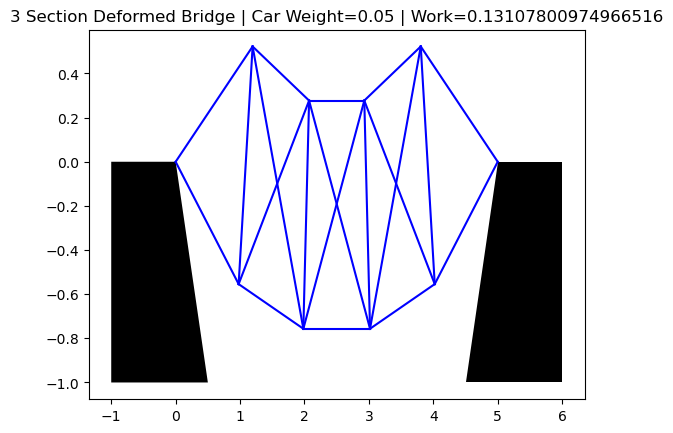

In [8]:
for nos in range(1,4):
    build_load_plot_basic_bridge(nos)

Questions answered

1. If you are driving a light-weight car (0.01 units of weight), what is the maximum length (in nos) the bridge could be while still being considered safe? (What is your criterion for “safe”?)
Recall that work is the energy transferred to or from an object via the application of force along a displacement. Thus, the greater the magnitude of the work done by the force on the bridge, the greater the displacement. We define arbitrarily that any work value greater than 0.05 (when rounded to one sig. fig) results in an unsafe verdict. This measurement is inspired by the p-value of statistics but it is still arbitrary. In this case, the bridge could be at most three sections long before it would be considered unsafe.

2. What about if you are driving an 18-wheeler truck (0.05 units of weight)?
Using the definition inspired by (1), the bridge could be at most one section long.

3. How does the spy of the adjacency matrix A for a particular bridge relate to how it deforms?
The adjacency matrix shows which beams are deformed with respect to which nodes. Since it relates along its two axes the beams to the nodes, any deformation in the nodes is experienced in the beams that are related to it in the adjacency matrix by having nonzero entries in those positions. The deformation of a bridge depends on the forces acting on its nodes and beams, and how they affect the displacements of the structure.

4. What trends do you notice as nos increases? (Relate your answer to the spy of a particular bridge, how the bridge deforms under different stress conditions, etc.)
As nos increases, the bridge deformation becomes more extreme. Notice that the spy plot continues to expand diagonally. Because the number of nodes expands faster than the number of beams in terms of sheer quantity, fewer beams are present to absorb the stress, so the deformation on each member is more extreme in each iteration. In the one section bridge for 0.05 force, work was only 0.021. However, in the three section bridge, it was a whopping 0.13-- over ten times as much deformation.